In [1]:
import asyncio
from pyppeteer import launch
from PIL import Image
import io

In [2]:
def savesession( ims ) :
    import os
    from datetime import datetime

    dirname = "session_" + str(datetime.now())
    os.mkdir(dirname)
    
    count = 0
    for im in ims :
        count += 1
        im.save( os.path.join(dirname, str(count) + "." + im.format) )
        
    return dirname

In [4]:
def solve( images ) :
    
    import requests
    from pydantic import BaseModel
    from typing import List
    from typing import Optional
    from PIL import Image
    import io
    import base64

    class Captcha(BaseModel):
        url: str
        imagedata: List[str]


    imagedata = []
    for im in images :
        output = io.BytesIO()
        im.save(output, format=im.format)
        #display(im)
        imagedata.append(base64.b64encode(output.getvalue()).decode('ascii'))
    c = Captcha(url="https:123.com", imagedata=imagedata)
    #print(c)
    #print(c.dict())

    r = requests.post("http://localhost:8000/captcha", json=c.dict())
    print("Status code:", r.status_code)
    print("Response:", r.json())
    return r.json()

In [2]:
async def main():
    browser = await launch()
    page = await browser.newPage()
    await page.goto('https://example.com')
    await page.screenshot({'path': 'example.png'})
    await browser.close()

asyncio.get_event_loop().run_until_complete(main())

RuntimeError: This event loop is already running

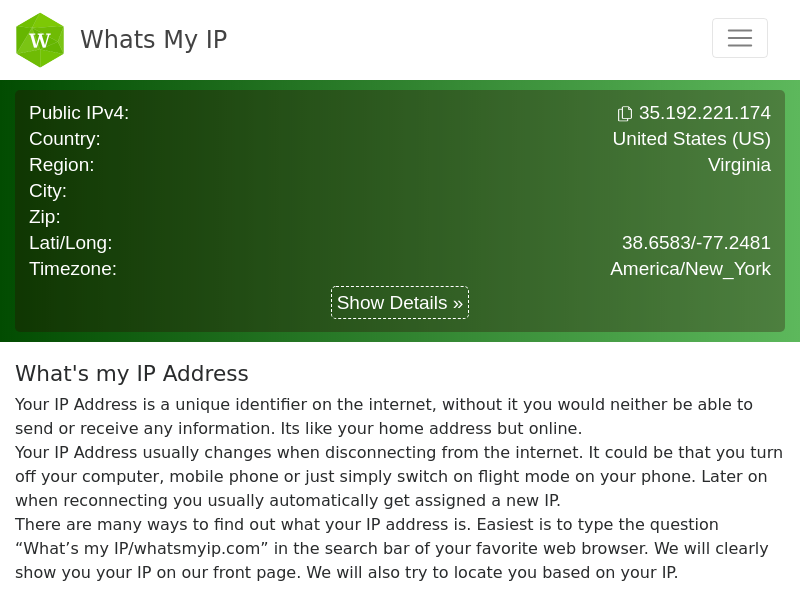

In [3]:
browser = await launch()
page = await browser.newPage()
await page.goto('https://whatsmyip.com')
await page.screenshot({'path': 'example.png'})
await browser.close()
display(Image.open('example.png'))

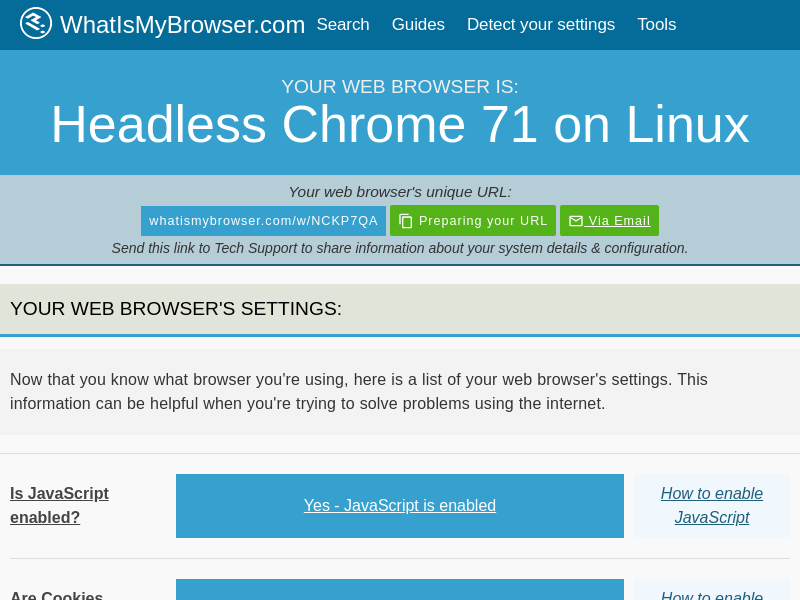

In [2]:
browser = await launch()
page = await browser.newPage()
await page.goto('https://whatismybrowser.com')
await page.screenshot({'path': 'example.png'})
await browser.close()
display(Image.open('example.png'))

# load IALTYO website and get captcha

In [35]:
browser = await launch(ignoreHTTPSErrors=True)
page = await browser.newPage()
url = 'https://www.interasia.cc/content/c_service/cargo_tracking.aspx?SiteID=1'
url_captcha = 'https://www.interasia.cc/WebTools/RandomCode.ashx?Code='
url_abort = 'google-analytics.com'

images = []

async def interceptRequest(interceptedRequest):
    if url_abort in interceptedRequest.url :
        #print("request abort: " + interceptedRequest.resourceType + " " + interceptedRequest.url )
        await interceptedRequest.abort()
        return        
    if interceptedRequest.resourceType != 'image' :
        #print("request contd: " + interceptedRequest.resourceType + " " + interceptedRequest.url )
        await interceptedRequest.continue_()
        return
    if url_captcha not in interceptedRequest.url :
        #print("request abort: " + interceptedRequest.resourceType + " " + interceptedRequest.url )
        await interceptedRequest.abort()
        return
    #print("request contd: " + interceptedRequest.resourceType + " " + interceptedRequest.url )
    await interceptedRequest.continue_()
page.on('request', lambda interceptedRequest: asyncio.ensure_future(interceptRequest(interceptedRequest)))
await page.setRequestInterception(True)

async def interceptResponse(interceptedResponse):
    if url_captcha not in interceptedResponse.request.url :
    #if interceptedResponse.request.resourceType != 'image':
        return
    #print("response: " + interceptedResponse.request.resourceType + " " + interceptedResponse.request.url )
    image = Image.open(io.BytesIO(await interceptedResponse.buffer()))
    #display(image)
    images.append(image)
page.on('response', lambda interceptedResponse: asyncio.ensure_future(interceptResponse(interceptedResponse)))

await page.goto(url)
await page.screenshot({'path': 'example.png', 'fullPage': 'true'})
cont = await page.content()

await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)
await page.goto(url_captcha)

await browser.close()
#display(Image.open('example.png'))
#print(cont)

display( images[0] )
dirname = savesession( images )
print("saved images to " + dirname)

Task exception was never retrieved
future: <Task finished coro=<async-def-wrapper.<locals>.interceptResponse() done, defined at /tmp/ipykernel_266/1604841437.py:30> exception=NetworkError('Protocol error Network.getResponseBody: Target closed.')>
Traceback (most recent call last):
  File "/tmp/ipykernel_266/1604841437.py", line 35, in interceptResponse
    page.on('response', lambda interceptedResponse: asyncio.ensure_future(interceptResponse(interceptedResponse)))
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/pyppeteer/network_manager.py", line 654, in _bufread
    'requestId': self._request._requestId
pyppeteer.errors.NetworkError: Protocol error Network.getResponseBody: Target closed.


saved images to session_2022-01-03 21:06:51.863878


# solve captchas

In [36]:
from collections import Counter

result = Counter(solve( images ))
mostcommon = result.most_common(1)[0][0]
print(str(result) + " -> " + mostcommon)

Status code: 200
Response: {'A50M': 12, '50M': 2, 'A50OM': 2}
Counter({'A50M': 12, '50M': 2, 'A50OM': 2}) -> A50M


In [37]:
import os

os.rename( dirname, os.path.join('IALTYO_reload',mostcommon))